## Build an ML Model in PyTorch

In [1]:
# https://github.com/memlabs-research/build-a-quant-trading-strategy

In [2]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities

# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import data.binance                              # Binance market data utilities

In [3]:
research.set_seed(42)

In [4]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)  # Show all columns

polars.config.Config

In [5]:
# Trading pair symbol
sym = 'BTCUSDT'
# time horizon of time series (time interval)
time_interval = '1h'
# Max number of auto-regressive lags
max_lags = 4
# Forecast horizon in steps 
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)

In [6]:
start_date = datetime(2024, 10, 29, 0, 0)
end_date = datetime(2025, 10, 9, 0, 0)
data.binance.download_date_range(sym, start_date, end_date)

In [7]:
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)
ts

Loading BTCUSDT: 100%|██████████| 346/346 [00:17<00:00, 19.49day/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6
…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8


In [8]:
research.load_timeseries_range(sym, time_interval, start_date, end_date, pl.col('price').quantile(0.5).alias('price_median'))

Loading BTCUSDT: 100%|██████████| 346/346 [00:17<00:00, 19.42day/s]


datetime,price_median
datetime[μs],f64
2024-10-29 00:00:00,69848.5
2024-10-29 01:00:00,69969.0
2024-10-29 02:00:00,71180.1
2024-10-29 03:00:00,71170.5
2024-10-29 04:00:00,71029.3
…,…
2025-10-09 19:00:00,120839.8
2025-10-09 20:00:00,120942.8
2025-10-09 21:00:00,121300.7


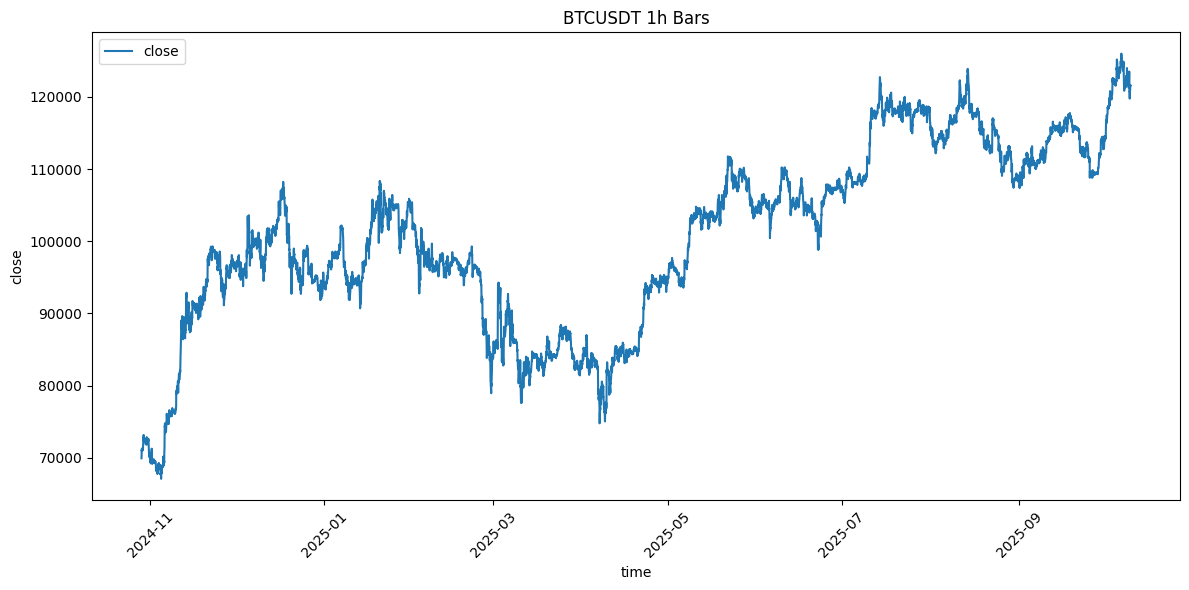

In [9]:
research.plot_static_timeseries(ts, sym, 'close', time_interval)

In [10]:
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, 'close', time_interval)

alt.Chart(...)

### Feature Engineering

In [11]:
price_time_series = pl.DataFrame({'price':[100.0,120.0,100.0]})
research.plot_column(price_time_series, 'price')

alt.Chart(...)

In [12]:
price_time_series.with_columns(
    pl.col('price').diff().alias('delta'),
    ((pl.col('price')-pl.col('price').shift())/pl.col('price').shift()).alias('return'),
    (pl.col('price')/pl.col('price').shift()).log().alias('log_return'),
)

price,delta,return,log_return
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


### Create target and lagged features

In [13]:
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return'))
ts

datetime,open,high,low,close,close_log_return
datetime[μs],f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903
…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989


In [14]:
target = 'close_log_return'
lr = pl.col(target)
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias(f'{target}_lag_1'),
    lr.shift(forecast_horizon * 2).alias(f'{target}_lag_2'),
    lr.shift(forecast_horizon * 3).alias(f'{target}_lag_3'),
    lr.shift(forecast_horizon * 4).alias(f'{target}_lag_4'),
)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [15]:
ts = research.add_lags(ts, target, max_lags, forecast_horizon)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-09 19:00:00,120600.0,121060.1,120600.0,120897.6,0.002465,-0.002613,0.009669,-0.011023,-0.001285
2025-10-09 20:00:00,120897.6,121147.2,120787.9,121045.4,0.001222,0.002465,-0.002613,0.009669,-0.011023
2025-10-09 21:00:00,121045.3,121457.2,120998.3,121407.8,0.002989,0.001222,0.002465,-0.002613,0.009669


In [16]:
ts = ts.drop_nulls()

In [17]:
research.plot_distribution(ts, target, no_bins = 100)

alt.Chart(...)

In [18]:
research.plot_distribution(ts, 'close', no_bins = 100)

alt.Chart(...)

### Build Model

In [19]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

### Complexity of the model

##### y = w * x + b

In [20]:
input_features = 1

linear_model = LinearModel(input_features)

research.print_model_info(linear_model, "Linear Model")
research.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



2

### Split by time

In [21]:
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

In [22]:
print(len(ts))
print(int(len(ts) * test_size))
split_idx = int(len(ts) * (1-test_size))
split_idx

8299
2074


6224

In [23]:
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [24]:
ts_train.tail(3)

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-07-15 10:00:00,116765.0,117222.2,116728.1,117055.0,0.002481,-0.000014,-0.000091,-0.002343,-0.002341
2025-07-15 11:00:00,117055.0,117180.0,116331.7,117110.4,0.000473,0.002481,-0.000014,-0.000091,-0.002343
2025-07-15 12:00:00,117110.4,117458.6,116388.0,117193.1,0.000706,0.000473,0.002481,-0.000014,-0.000091


In [25]:
ts_test.head(3)

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-07-15 13:00:00,117193.0,118499.8,117132.6,118067.7,0.007435,0.000706,0.000473,0.002481,-0.000014
2025-07-15 14:00:00,118067.8,118439.2,115678.1,115979.6,-0.017844,0.007435,0.000706,0.000473,0.002481
2025-07-15 15:00:00,115979.6,116752.9,115750.1,116393.0,0.003558,-0.017844,0.007435,0.000706,0.000473


In [26]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = ts_test[features].to_torch().float() # polars method
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)

In [27]:
X_train

tensor([[ 1.9030e-03],
        [-7.2779e-04],
        [ 3.0330e-03],
        ...,
        [-1.3703e-05],
        [ 2.4814e-03],
        [ 4.7317e-04]])

In [28]:
X_train.shape

torch.Size([6224, 1])

In [29]:
y_train

tensor([-0.0007,  0.0030, -0.0031,  ...,  0.0025,  0.0005,  0.0007])

In [30]:
y_train.shape

torch.Size([6224])

In [31]:
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-0.0007],
        [ 0.0030],
        [-0.0031],
        ...,
        [ 0.0025],
        [ 0.0005],
        [ 0.0007]])

In [32]:
y_train.shape

torch.Size([6224, 1])

In [33]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[ 0.0074],
        [-0.0178],
        [ 0.0036],
        ...,
        [ 0.0030],
        [ 0.0017],
        [-0.0003]])

In [34]:
research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[ 1.9030e-03],
         [-7.2779e-04],
         [ 3.0330e-03],
         ...,
         [-1.3703e-05],
         [ 2.4814e-03],
         [ 4.7317e-04]]),
 tensor([[ 0.0007],
         [ 0.0074],
         [-0.0178],
         ...,
         [ 0.0012],
         [ 0.0030],
         [ 0.0017]]),
 tensor([[-0.0007],
         [ 0.0030],
         [-0.0031],
         ...,
         [ 0.0025],
         [ 0.0005],
         [ 0.0007]]),
 tensor([[ 0.0074],
         [-0.0178],
         [ 0.0036],
         ...,
         [ 0.0030],
         [ 0.0017],
         [-0.0003]]))

### Batch Gradient Descent

In [35]:
# hyperparameters
no_epochs = 1000 * 5
lr = 0.0005

# create model
model = LinearModel(len(features))
# loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

print("\nTraining model...")

for epoch in range(no_epochs):
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)

    # backward pass
    optimizer.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    optimizer.step()        # 3. update weights

    # check for improvement
    train_loss = loss.item()

    # logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}")

print("\nLearned parameters")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}")
    


Training model...
Epoch [500/5000], Loss: 0.468828
Epoch [1000/5000], Loss: 0.234599
Epoch [1500/5000], Loss: 0.101732
Epoch [2000/5000], Loss: 0.036157
Epoch [2500/5000], Loss: 0.009766
Epoch [3000/5000], Loss: 0.001831
Epoch [3500/5000], Loss: 0.000232
Epoch [4000/5000], Loss: 0.000041
Epoch [4500/5000], Loss: 0.000029
Epoch [5000/5000], Loss: 0.000028

Learned parameters
linear.weight:
[[-0.0538914]]
linear.bias:
[0.00013368]

Test Loss: 0.000011, Train Loss: 0.000028


### Test Trading Peformance

In [36]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.000096,0.007435,true,1.0,0.007435,0.007435
-0.000267,-0.017844,true,-1.0,0.017844,0.025279
0.001095,0.003558,true,1.0,0.003558,0.028837
-0.000058,0.006874,false,-1.0,-0.006874,0.021963
-0.000237,0.001873,false,-1.0,-0.001873,0.02009
…,…,…,…,…,…
0.000275,0.002465,true,1.0,0.002465,0.018513
8.6137e-7,0.001222,true,1.0,0.001222,0.019735
0.000068,0.002989,true,1.0,0.002989,0.022724


In [37]:
research.plot_column(trade_results, 'equity_curve')

alt.Chart(...)

In [38]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000096,0.007435,true,1.0,0.007435,0.007435,0.0
-0.000267,-0.017844,true,-1.0,0.017844,0.025279,0.0
0.001095,0.003558,true,1.0,0.003558,0.028837,0.0
-0.000058,0.006874,false,-1.0,-0.006874,0.021963,-0.006874
-0.000237,0.001873,false,-1.0,-0.001873,0.02009,-0.008747
…,…,…,…,…,…,…
0.000275,0.002465,true,1.0,0.002465,0.018513,-0.077479
8.6137e-7,0.001222,true,1.0,0.001222,0.019735,-0.076257
0.000068,0.002989,true,1.0,0.002989,0.022724,-0.073268


In [39]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.14714768528938293

In [40]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.1368335089903927)

In [41]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-136.83350899039272)

In [42]:
win_rate = trade_results['is_won'].mean()
win_rate

0.4959036144578313

In [43]:
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss
ev

9.952400906535321e-06

In [44]:
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

0.020651236176490784

In [45]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(1.020865948431715)

In [46]:
1000*compound_return

np.float64(1020.8659484317151)

In [47]:
equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.05115584656596184

In [48]:
equity_peak = trade_results['equity_curve'].max()
equity_peak

0.0959918349981308

In [49]:
std = trade_results['trade_log_return'].std()
std

0.0033079273998737335

In [50]:
sharpe = ev / std * annualized_rate
sharpe

np.float64(0.2815943558905409)

In [51]:
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 2075,
 'win_rate': 0.4959036144578313,
 'avg_win': 0.0022900966530581563,
 'avg_loss': -0.002233134057472067,
 'best_trade': 0.02901790291070938,
 'worst_trade': -0.02237566001713276,
 'ev': 9.952400906535321e-06,
 'std': 0.0033079273998737335,
 'total_log_return': 0.020651236176490784,
 'compound_return': np.float64(1.020865948431715),
 'max_drawdown': -0.14714768528938293,
 'equity_trough': -0.05115584656596184,
 'equity_peak': 0.0959918349981308,
 'sharpe': np.float64(0.2815943558905437)}

In [52]:
target = 'close_log_return'
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
perf = research.benchmark_reg_model(ts, features, target, model, annualized_rate, no_epochs=50)
perf

{'features': 'close_log_return_lag_2',
 'target': 'close_log_return',
 'no_trades': 2075,
 'win_rate': 0.5195180722891566,
 'avg_win': 0.002268987163207711,
 'avg_loss': -0.002253158995160193,
 'best_trade': 0.02901790291070938,
 'worst_trade': -0.019244860857725143,
 'ev': 9.617765964491532e-05,
 'std': 0.0033065432216972113,
 'total_log_return': 0.19956862926483154,
 'compound_return': np.float64(1.220875994377854),
 'max_drawdown': -0.2002187967300415,
 'equity_trough': -0.0351303368806839,
 'equity_peak': 0.22971779108047485,
 'sharpe': np.float64(2.722400739060691),
 'weights': '[-0.02532571]',
 'biases': '7.390046084765345e-05'}

In [53]:
import itertools

benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))

for features in combos:    
    model = LinearModel(len(features))
    benchmarks.append(research.benchmark_reg_model(ts, list(features), target, model, annualized_rate, test_size=test_size, no_epochs=50, loss=nn.L1Loss()))

benchmark = pl.DataFrame(benchmarks)
benchmark.sort('sharpe', descending=True)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_2""","""close_log_return""",2075,0.519518,0.002275,-0.002247,0.029018,-0.019245,0.000102,0.003306,0.211727,1.23581,-0.202473,-0.020766,0.241876,2.888405,"""[-0.02565782]""","""7.57822344894521e-05"""
"""close_log_return_lag_3""","""close_log_return""",2075,0.501205,0.0023,-0.002223,0.029018,-0.022376,0.000044,0.003308,0.091227,1.095517,-0.254687,-0.202833,0.091558,1.244047,"""[-0.03208822]""","""9.00311060831882e-05"""
"""close_log_return_lag_4""","""close_log_return""",2075,0.499759,0.00228,-0.002243,0.029018,-0.022376,0.000018,0.003308,0.036744,1.037427,-0.142968,-0.08755,0.072348,0.501032,"""[-0.00135242]""","""7.224217551993206e-05"""
"""close_log_return_lag_1""","""close_log_return""",2075,0.495422,0.002295,-0.002228,0.029018,-0.022376,0.000013,0.003308,0.026936,1.027302,-0.203701,0.007435,0.215534,0.367288,"""[-0.07185663]""","""9.117424633586779e-05"""


In [54]:
research.auto_reg_corr_matrx(ts, target, max_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
f64,f64,f64,f64,f64
1.0,-0.020527,0.004165,-0.024077,0.006435
-0.020527,1.0,-0.020555,0.004284,-0.024028
0.004165,-0.020555,1.0,-0.020793,0.004187
-0.024077,0.004284,-0.020793,1.0,-0.020495
0.006435,-0.024028,0.004187,-0.020495,1.0


In [55]:
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts, features, target, model, no_epochs=200, loss=nn.L1Loss())

research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

## Add Transaction Fees

In [56]:
maker_fee = 0.0001
taker_fee = 0.0003

roundtrip_fee_log = np.log(1 - 2 * taker_fee)

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
model_trades = model_trades.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')).alias('trade_log_return_net'))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))

model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64
0.000061,0.007435,true,1.0,0.007435,0.007435,0.0,-0.0006,0.006835,0.006835
0.000055,-0.017844,false,1.0,-0.017844,-0.010409,-0.017844,-0.0006,-0.018444,-0.011609
-0.000117,0.003558,false,-1.0,-0.003558,-0.013967,-0.021402,-0.0006,-0.004158,-0.015767
0.000528,0.006874,true,1.0,0.006874,-0.007092,-0.014527,-0.0006,0.006274,-0.009493
-0.000018,0.001873,false,-1.0,-0.001873,-0.008965,-0.0164,-0.0006,-0.002473,-0.011966
…,…,…,…,…,…,…,…,…,…
-0.000173,0.002465,false,-1.0,-0.002465,0.166913,-0.049873,-0.0006,-0.003065,-1.076059
0.00014,0.001222,true,1.0,0.001222,0.168135,-0.048651,-0.0006,0.000622,-1.075438
0.00001,0.002989,true,1.0,0.002989,0.171125,-0.045661,-0.0006,0.002389,-1.073049


In [57]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [58]:
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net,trade_log_return_net_maker,trade_log_return_net_taker,equity_curve_net_maker,equity_curve_net_taker
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64
0.000061,0.007435,true,1.0,0.007435,0.007435,0.0,-0.0006,0.006835,0.006835,-9.202905,-8.104293,-9.202905,-8.104293
0.000055,-0.017844,false,1.0,-0.017844,-0.010409,-0.017844,-0.0006,-0.018444,-0.011609,-9.228184,-8.129572,-18.431089,-16.233865
-0.000117,0.003558,false,-1.0,-0.003558,-0.013967,-0.021402,-0.0006,-0.004158,-0.015767,-9.213898,-8.115286,-27.644988,-24.349151
0.000528,0.006874,true,1.0,0.006874,-0.007092,-0.014527,-0.0006,0.006274,-0.009493,-9.203466,-8.104854,-36.848454,-32.454005
-0.000018,0.001873,false,-1.0,-0.001873,-0.008965,-0.0164,-0.0006,-0.002473,-0.011966,-9.212213,-8.113601,-46.060667,-40.567606
…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.000173,0.002465,false,-1.0,-0.002465,0.166913,-0.049873,-0.0006,-0.003065,-1.076059,-9.212805,-8.114193,-19074.447997,-16799.221947
0.00014,0.001222,true,1.0,0.001222,0.168135,-0.048651,-0.0006,0.000622,-1.075438,-9.209119,-8.110506,-19083.657115,-16807.332453
0.00001,0.002989,true,1.0,0.002989,0.171125,-0.045661,-0.0006,0.002389,-1.073049,-9.207351,-8.108739,-19092.864466,-16815.441192


### Research 6h Forecast Horizon

In [59]:
time_interval = '6h'
ts = research.load_ohlc_timeseries_range(sym, time_interval, start_date, end_date)
ts

Loading BTCUSDT: 100%|██████████| 346/346 [00:17<00:00, 19.88day/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71010.9
2024-10-29 06:00:00,71010.8,71580.0,70803.0,71440.1
2024-10-29 12:00:00,71440.0,72972.0,70900.0,72700.8
2024-10-29 18:00:00,72700.8,73660.0,71871.1,72739.5
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72516.3
…,…,…,…,…
2025-10-08 18:00:00,123985.5,124169.2,122739.7,123237.5
2025-10-09 00:00:00,123237.4,123279.7,121411.8,122052.6
2025-10-09 06:00:00,122052.6,122777.0,121081.5,122672.9


In [60]:
no_lags = 3
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71010.9,null,null,null,null
2024-10-29 06:00:00,71010.8,71580.0,70803.0,71440.1,0.006026,null,null,null
2024-10-29 12:00:00,71440.0,72972.0,70900.0,72700.8,0.017493,0.006026,null,null
2024-10-29 18:00:00,72700.8,73660.0,71871.1,72739.5,0.000532,0.017493,0.006026,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72516.3,-0.003073,0.000532,0.017493,0.006026
…,…,…,…,…,…,…,…,…
2025-10-08 18:00:00,123985.5,124169.2,122739.7,123237.5,-0.006051,0.009398,0.012186,0.000425
2025-10-09 00:00:00,123237.4,123279.7,121411.8,122052.6,-0.009661,-0.006051,0.009398,0.012186
2025-10-09 06:00:00,122052.6,122777.0,121081.5,122672.9,0.005069,-0.009661,-0.006051,0.009398


In [61]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_2""","""close_log_return""",345,0.550725,0.005243,-0.005837,0.041011,-0.027085,0.000265,0.007678,0.091406,1.095714,-0.107804,-0.077902,0.100361,3.229774,"""[-0.06619783]""","""0.0004998851218260825"""
"""close_log_return_lag_1""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00758725]""","""0.0004667193570639938"""
"""close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00386025]""","""0.0004668111214414239"""


In [62]:
research.auto_reg_corr_matrx(ts.drop_nulls(), target, no_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
f64,f64,f64,f64
1.0,-0.009991,-0.05972,-0.009533
-0.009991,1.0,-0.009586,-0.059841
-0.05972,-0.009586,1.0,-0.00873
-0.009533,-0.059841,-0.00873,1.0


In [63]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.L1Loss(), test_size=0.3)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",415,0.544578,0.005387,-0.005399,0.041011,-0.027085,0.000475,0.007681,0.197133,1.217906,-0.103148,-0.000011,0.233454,5.788155,"""[-0.025877]""","""0.00023957113444339484"""
"""close_log_return_lag_3""","""close_log_return""",415,0.53253,0.005503,-0.005267,0.041011,-0.027085,0.000469,0.007681,0.194468,1.214664,-0.13558,-0.010205,0.250161,5.709613,"""[-0.05904009]""","""0.0004449005064088851"""
"""close_log_return_lag_2""","""close_log_return""",415,0.549398,0.005155,-0.005682,0.028236,-0.041011,0.000272,0.007691,0.112835,1.119448,-0.16492,-0.032449,0.137133,3.308776,"""[-0.08242514]""","""0.0004675187810789794"""


In [64]:
features = ['close_log_return_lag_1']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss(), no_epochs=100)
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [65]:
maker_fee = 0.0001
taker_fee = 0.0003

roundtrip_fee_log = np.log(1 - 2 * taker_fee)

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
model_trades = model_trades.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')).alias('trade_log_return_net'))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))

research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [66]:
research.plot_column(model_trades, 'equity_curve_net_taker') # issue with the .add_tx_fees_log fn

alt.Chart(...)

## Research 12 forecast horizon

In [67]:
time_interval = '12h'

In [68]:
no_lags = 4
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71010.9,null,null,null,null,null
2024-10-29 06:00:00,71010.8,71580.0,70803.0,71440.1,0.006026,null,null,null,null
2024-10-29 12:00:00,71440.0,72972.0,70900.0,72700.8,0.017493,0.006026,null,null,null
2024-10-29 18:00:00,72700.8,73660.0,71871.1,72739.5,0.000532,0.017493,0.006026,null,null
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72516.3,-0.003073,0.000532,0.017493,0.006026,null
…,…,…,…,…,…,…,…,…,…
2025-10-08 18:00:00,123985.5,124169.2,122739.7,123237.5,-0.006051,0.009398,0.012186,0.000425,0.001761
2025-10-09 00:00:00,123237.4,123279.7,121411.8,122052.6,-0.009661,-0.006051,0.009398,0.012186,0.000425
2025-10-09 06:00:00,122052.6,122777.0,121081.5,122672.9,0.005069,-0.009661,-0.006051,0.009398,0.012186


In [69]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.556522,0.005341,-0.005722,0.041011,-0.027085,0.000435,0.00767,0.149936,1.16176,-0.094845,-0.035114,0.158891,5.303259,"""[-0.00820176 -0.06570604 -0.00454499]""","""0.0005025768186897039"""
"""close_log_return_lag_2""","""close_log_return""",345,0.550725,0.005243,-0.005837,0.041011,-0.027085,0.000265,0.007678,0.091406,1.095714,-0.107804,-0.077902,0.100361,3.229774,"""[-0.06550111]""","""0.0004963802057318389"""
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",345,0.547826,0.00525,-0.005824,0.041011,-0.027085,0.000243,0.007679,0.083798,1.08741,-0.105424,-0.062388,0.092753,2.960678,"""[-0.0075135 -0.06728575]""","""0.0004915987374261022"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.542029,0.005291,-0.005768,0.041011,-0.027085,0.000226,0.007679,0.078095,1.081226,-0.105911,-0.076008,0.08705,2.759004,"""[-0.0664894 -0.00435301]""","""0.0004902316140942276"""
"""close_log_return_lag_1""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00710891]""","""0.0004693868395406753"""
"""close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00358864]""","""0.00046924667549319565"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00266266 -0.00989027]""","""0.000463845586637035"""


In [70]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",345,0.553623,0.005308,-0.005759,0.041011,-0.027085,0.000368,0.007674,0.127005,1.135423,-0.096249,-0.062197,0.13596,4.490131,"""[-0.00749033 -0.06727477]""","""0.000509694975335151"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.547826,0.005308,-0.005754,0.041011,-0.027085,0.000306,0.007676,0.105433,1.111191,-0.096249,-0.050819,0.114387,3.72613,"""[-0.06637757 -0.00423167]""","""0.0005068190512247384"""
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.547826,0.005281,-0.005786,0.041011,-0.027085,0.000277,0.007677,0.09556,1.100275,-0.096249,-0.035114,0.104515,3.376731,"""[-0.00644355 -0.06652328 -0.00492279]""","""0.0004986324347555637"""
"""close_log_return_lag_2""","""close_log_return""",345,0.542029,0.005203,-0.005872,0.041011,-0.027085,0.000131,0.007681,0.045259,1.046299,-0.107804,-0.085454,0.054214,1.598471,"""[-0.06582798]""","""0.0005011773901060224"""
"""close_log_return_lag_1""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00789653]""","""0.00047444505617022514"""
"""close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00401073]""","""0.00047311931848526"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005203,-0.005868,0.041011,-0.027085,0.000101,0.007682,0.034847,1.035461,-0.134433,-0.085338,0.064474,1.230666,"""[-0.00243224 -0.00978289]""","""0.0004791847604792565"""


In [71]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.L1Loss(), test_size=0.25)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.573913,0.005446,-0.005595,0.041011,-0.027085,0.000742,0.007646,0.255845,1.291553,-0.089545,0.002746,0.2648,9.077246,"""[-0.02835546 -0.0809136 -0.05975669]""","""0.0005907449522055686"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",345,0.556522,0.005499,-0.005523,0.041011,-0.027085,0.000611,0.007658,0.210713,1.234558,-0.136003,0.002746,0.219668,7.464673,"""[-0.06655551 -0.06363799]""","""0.0005872977781109512"""
"""close_log_return_lag_1""","""close_log_return""",345,0.556522,0.0054,-0.005648,0.041011,-0.027085,0.0005,0.007666,0.172627,1.188423,-0.103148,-0.014506,0.208948,6.109042,"""[-0.02604083]""","""0.00022798110148869455"""
"""close_log_return_lag_3""","""close_log_return""",345,0.542029,0.005403,-0.005636,0.041011,-0.027085,0.000347,0.007674,0.119807,1.12728,-0.112034,0.002746,0.145894,4.235127,"""[-0.05107518]""","""0.0004729770589619875"""
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",345,0.550725,0.005234,-0.005848,0.041011,-0.027085,0.000255,0.007678,0.088012,1.092001,-0.10402,-0.062197,0.096966,3.109698,"""[-0.02263798 -0.08145907]""","""0.0005154152167961001"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",345,0.53913,0.005293,-0.005763,0.041011,-0.027085,0.000198,0.00768,0.068204,1.070584,-0.115989,-0.044216,0.103426,2.409312,"""[-0.06199357 -0.02166073]""","""0.0003283640544395894"""
"""close_log_return_lag_2""","""close_log_return""",345,0.553623,0.005128,-0.005983,0.023101,-0.041011,0.000169,0.007681,0.058194,1.059921,-0.16492,-0.082428,0.082492,2.055534,"""[-0.08119194]""","""0.00046581318019889295"""


### Save Best Model (Sharpe 10 Model)

In [72]:
features = ['close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss())
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [73]:
torch.save(model.state_dict(), 'model_weights/model_weights.pth')